## Installing and Importing Dependencies

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

# opencv - preprocessing
# matplotlib - rendering the results (seeing outputs of preprocessed videos)
# imageio - to see other frames stacked together
# gdown - downloading dataset
# tensorflow - building neural network

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.8 MB ? eta -:--:--
   - -------------------------------------- 1.0/38.8 MB 3.4 MB/s eta 0:00:12
   -- ------------------------------------- 2.1/38.8 MB 3.9 MB/s eta 0:00:10
   -- ------------------------------------- 2.9/38.8 MB 4.2 MB/s eta 0:00:09
   ---- ----------------------------------- 4.2/38.8 MB 4.5 MB/s eta 0:00:08
   ----- ---------------------------------- 5.2/38.8 MB 4.7 MB/s eta 0:00:08
   ------ --------------------------------- 6.3/38.8 MB 4.8 MB/s eta 0:00:07
   ------- -------------------------------- 7.6/38.8 MB 4.9 MB/s eta 0:00:07
   -------- ------------------------------- 8.7/38.8 MB 5.0 MB/s eta 0:00:07
   ---------- ----------------------------- 10.0/38.8 MB 5.1 MB/s eta 0:00:06
   ----------- ---------------------------- 11.3/38.8 MB 5.2 MB/s eta 0:00:06
   ------------ --------------------------- 12.6/38.8 MB 5.3 MB/s eta 0:00:05
   -------

In [1]:
!pip list

Package                           Version
--------------------------------- ------------------
absl-py                           2.1.0
aext-assistant                    4.0.15
aext-assistant-server             4.0.15
aext-core                         4.0.15
aext-core-server                  4.0.15
aext-panels                       4.0.15
aext-panels-server                4.0.15
aext-share-notebook               4.0.15
aext-share-notebook-server        4.0.15
aext-shared                       4.0.15
aiobotocore                       2.12.3
aiohappyeyeballs                  2.4.0
aiohttp                           3.10.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.3
anaconda-pro

In [3]:
import os # navigating through file systems in different operating systems
import cv2 # preprocessing and loading videos
import tensorflow as tf # modelling (tf.data - good data pipeline)
import numpy as np 
from typing import List 
import matplotlib.pyplot as plt
import imageio # array to a gif for preprocess

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
# Preventing exponential memory growth
physical_device = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

## Building Data Loading Functions

1. to load up videos
2. preprocess annotations (sentences and video lyrics)

In [11]:
import gdown

In [13]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8Jwjl'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8Jwjl

but Gdown can't. Please check connections and permissions.

In [15]:
# Data loading function

# take the data path and put a list of float represents a video
def load_video(path:str) -> List[float]:

    # creating cv2 instances and then looping through each of them and storing in array called frames
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])  # isolating mouth position
    cap.release()

    # scaling particular image features + 
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [17]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [19]:
# Converting nums to chars and vice versa (tokenizing each char)

# https://keras.io/examples/audio/ctc_asr/

# here i'm able to pass through this data to our loss function to calculate our overall loss bcs model gonna return one-hot-encoded version of this

char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)


print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [21]:
char_to_num(['a', 'l', 'm', 'a'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 1, 12, 13,  1], dtype=int64)>

In [23]:
char_to_num(['2', '0', '1', '4'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([31,  0, 30, 33], dtype=int64)>

In [25]:
# Function load to alignments

def load_alignments(path:str) -> List[str]: 

    # reading lines from a path into a list
    with open(path, 'r') as f: 
        lines = f.readlines() 

    # splitting up lines
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':   # line converts silence, we'll ignore it

            # appending them to a list named 'tokens'
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [27]:
# Loading the alignments and videos simultaneously.
# Extracting both of those paths and returning preprocessed videos + alignments together

def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [29]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [31]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\s1\\bbal6n.mpg'>

In [33]:
tf.convert_to_tensor(test_path).numpy()

b'.\\data\\s1\\bbal6n.mpg'

In [35]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [37]:
load_data(tf.convert_to_tensor(test_path))

# frames, height, width, number of channels(grayscale)

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[ 1.4603739 ],
          [ 1.4603739 ],
          [ 1.4209043 ],
          ...,
          [ 0.15787826],
          [ 0.19734782],
          [ 0.07893913]],
 
         [[ 1.4603739 ],
          [ 1.4603739 ],
          [ 1.4209043 ],
          ...,
          [ 0.15787826],
          [ 0.07893913],
          [ 0.03946957]],
 
         [[ 1.4209043 ],
          [ 1.4209043 ],
          [ 1.3814348 ],
          ...,
          [ 0.07893913],
          [ 0.07893913],
          [ 0.07893913]],
 
         ...,
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          ...,
          [ 9.94633   ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          ...,
          [ 9.90686   ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          

In [38]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [41]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.19734782],
         [ 0.07893913]],

        [[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209043 ],
         [ 1.4209043 ],
         [ 1.3814348 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.94633   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.86739

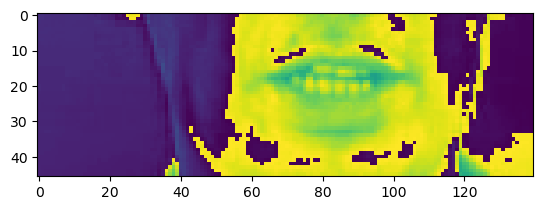

In [43]:
plt.imshow(frames[40])

# result of subtracting mean and std

In [45]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [47]:
# ERROR
num_to_char(alignments.numpy()).numpy().decode('utf-8')

AttributeError: 'numpy.ndarray' object has no attribute 'decode'

In [49]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [51]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [53]:
# Wrapping inside a mappable function that returns float32 and int64, using rawstring processing + assit in tensorflow pipelines

def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Data Pipelines
For training Deep Learning model: 
1. Tensorflow will draw random samples from our dataset in order to complete 1 training step.
2. Checking transformation is succesful.

In [57]:
import matplotlib.pyplot as plt

In [59]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')  # creating dataset
data = data.shuffle(500, reshuffle_each_iteration=False)  # shuffling the first 500
data = data.map(mappable_function)  # from data ocation to data itself
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))  # (2 videos + 2 sets of alignments), 75 frames, no pad img, 40 tokens
data = data.prefetch(tf.data.AUTOTUNE)  # !!! PREFETCHING
# Added for split 
train = data.take(450)
test = data.skip(450)

In [61]:
len(test)

50

In [63]:
frames, alignments = data.as_numpy_iterator().next()

In [64]:
len(frames)

2

In [67]:
sample = data.as_numpy_iterator()

In [69]:
val = sample.next(); val[0]

array([[[[[ 1.3030242 ],
          [ 1.3030242 ],
          [ 1.3413484 ],
          ...,
          [ 0.        ],
          [ 9.772681  ],
          [ 9.772681  ]],

         [[ 1.3030242 ],
          [ 1.3030242 ],
          [ 1.3413484 ],
          ...,
          [ 0.        ],
          [ 9.772681  ],
          [ 9.772681  ]],

         [[ 1.2646999 ],
          [ 1.2646999 ],
          [ 1.2646999 ],
          ...,
          [ 9.772681  ],
          [ 9.772681  ],
          [ 9.772681  ]],

         ...,

         [[ 0.88145757],
          [ 0.88145757],
          [ 0.88145757],
          ...,
          [ 9.466087  ],
          [ 9.466087  ],
          [ 9.466087  ]],

         [[ 0.88145757],
          [ 0.88145757],
          [ 0.88145757],
          ...,
          [ 9.466087  ],
          [ 9.466087  ],
          [ 9.466087  ]],

         [[ 0.88145757],
          [ 0.88145757],
          [ 0.88145757],
          ...,
          [ 9.466087  ],
          [ 9.466087  ],
          

In [71]:
test = data.as_numpy_iterator()

In [73]:
val = sample.next(); val[0]

array([[[[[1.4295915 ],
          [1.4295915 ],
          [1.4295915 ],
          ...,
          [0.3385875 ],
          [0.30096665],
          [0.30096665]],

         [[1.4295915 ],
          [1.3919708 ],
          [1.3167291 ],
          ...,
          [0.3385875 ],
          [0.30096665],
          [0.30096665]],

         [[1.4672124 ],
          [1.4672124 ],
          [1.4295915 ],
          ...,
          [0.3385875 ],
          [0.30096665],
          [0.30096665]],

         ...,

         [[1.0910041 ],
          [1.0533832 ],
          [1.0533832 ],
          ...,
          [0.03762083],
          [0.03762083],
          [0.03762083]],

         [[1.0533832 ],
          [1.0533832 ],
          [1.0533832 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.0533832 ],
          [1.0533832 ],
          [1.0533832 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]]],


        [[[1.4672

In [75]:
import warnings
warnings.filterwarnings('ignore')

In [77]:
imageio.mimsave('./animation.gif', val[0][1], fps = 10)  # bsc 0 or 1 - 2 sets of videos

Lossy conversion from float32 to uint8. Range [0.0, 9.731514930725098]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.731514930725098]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.731514930725098]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.731514930725098]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.731514930725098]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.731514930725098]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.731514930725098]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

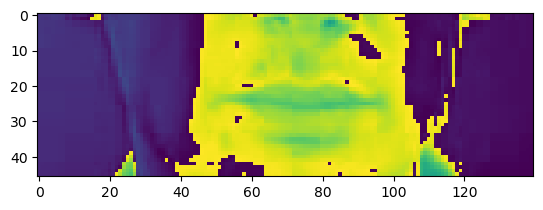

In [79]:
plt.imshow(val[0][0][0])  # videos, give me the first of the batch, return the first frame in the video

In [81]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])  # preprocessed annotation

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green at n five soon'>

## Design the Deep Neural Network
1. 3D convolutions to pass the videos
2. Condensing it down to a classification dense layer to predict characters
3. Loss function to predict single letters each time (**CTC - Connectionist Temporal Classification**)

   3.1 Why - works great when there are word transcriptions that aren't specifically aligned to frames (**`research - standard cross-entropy loss function`**)
   
   3.2 Reduces duplicates using special tokens
   
   3.3 Dataset was aligned? - when it comes to subbing out the data with data we created, it's gonna be way more cost-effective to use non-aligned data. 

In [85]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [87]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [89]:
from keras.layers import Reshape

In [141]:
# model = Sequential()
# model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(Conv3D(256, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(Conv3D(75, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(TimeDistributed(Flatten()))

# model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(0.5))

# model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(0.5))

# model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))  # (75, 23, 70, 128)

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))  # (75, 11, 35, 256)

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
# Remove this MaxPool3D or use smaller pooling
# model.add(MaxPool3D((1,2,2)))  # Comment this out

model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [143]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)                    │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 75, 28875)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 75, 256)             │      29,700,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,511,924 (120.21 MB)

 Trainable params: 31,511,924 (120.21 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
5*17*75

6375

In [147]:
# paper with code grid corpus

In [149]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [151]:
yhat[0].shape

(75, 41)

In [153]:
tf.argmax(yhat[0], axis = 1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([40,  2,  2, 22, 22, 22, 22, 22, 22, 22,  7,  7, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7, 39, 39, 39], dtype=int64)>

In [155]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'bbvvvvvvvggggggggggggggggggggggggggggggggggggggggggg   '>

In [157]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bbvvvvvvvggggggggggggggggggggggggggggggggggggggggggg   '>

In [159]:
model.input_shape

(None, 75, 46, 140, 1)

In [161]:
model.output_shape

(None, 75, 41)

## Setup Training Options and Train

In [165]:
# finding learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [167]:
# the codes below applies to audios, I'll apply them into our videos

# def CTCLoss(y_true, y_pred):
#     # Compute the training-time loss value
#     batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
#     input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
#     label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

#     input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#     label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

#     loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
#     return loss


In [169]:
# defining CTC loss - Automatic speech recognition using CTC

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [171]:
# class ProduceExample(tf.keras.callbacks.Callback): 
#     def __init__(self, dataset) -> None: 
#         self.dataset = dataset.as_numpy_iterator()
    
#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
#         for x in range(len(yhat)):           
#             print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
#             print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
#             print('~'*100)

In [173]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        # Check if the dataset is already a NumpyIterator
        if hasattr(dataset, "as_numpy_iterator"):
            self.dataset = dataset.as_numpy_iterator()
        else:
            self.dataset = dataset  # Use the dataset as is if it's already a NumpyIterator
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        # Get the next batch of data
        data = next(self.dataset)

        # Perform predictions
        yhat = self.model.predict(data[0])

        # Decode predictions
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        
        # Print original and predicted text for each example in the batch
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)


In [175]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [177]:
# where to save the MODEL
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True) 

In [179]:
# Dropping learning rate each epoch 
schedule_callback = LearningRateScheduler(scheduler)

In [181]:
# Help to make some predictions after each epoch to see how well our model is training
example_callback = ProduceExample(test)

In [183]:
from tensorflow import keras

In [185]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node sequential_1_1/time_distributed_1_1/Reshape_50 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\Lenovo\anaconda3\Lib\asyncio\windows_events.py", line 322, in run_forever

  File "C:\Users\Lenovo\anaconda3\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\Lenovo\anaconda3\Lib\asyncio\base_events.py", line 1986, in _run_once

  File "C:\Users\Lenovo\anaconda3\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5060\986682723.py", line 1, in <module>

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 371, in fit

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 219, in function

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 132, in multi_step_on_iterator

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 113, in one_step_on_data

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 57, in train_step

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 908, in __call__

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\models\sequential.py", line 213, in call

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 637, in call

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 908, in __call__

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in call

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 102, in step_function

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\ops\numpy.py", line 4868, in reshape

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1915, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1_1/time_distributed_1_1/Reshape_50}}]] [Op:__inference_multi_step_on_iterator_62301]

In [187]:
print("Train dataset element spec:", train.element_spec)
print("Test dataset element spec:", test.element_spec)

# Check actual batch shapes
for batch in train.take(1):
    print("Input batch shape:", batch[0].shape)
    print("Target batch shape:", batch[1].shape)
    break

Train dataset element spec: (TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))


AttributeError: 'NumpyIterator' object has no attribute 'element_spec'